# Demonstration of iLPCNet

This notebook is on iLPCNet:
    
1. It defines components in the model
2. It loads pre-trained model and generate waveform samples


A few notes:
* The original paper is https://arxiv.org/abs/2001.11686;
* There are some differences:
    * This implementation does not assume a specific type of input acoustic features. Although we use Mel-spec here, the model can be trained using other features too. Input features will be converted to reflection coefficients using a small DNN. See more details in Section 1;
    * Detailed structure are slightly different: no trans conv for up-sampling ...
* Details on linear prediction are covered by c11_linear_prediction.ipynb;

Your comments are welcome!

The project to train and run a iLPCNet on CMU arctic database is available in `../project/05-nn-vocoder/iLPCNet`.


## 1. Definition of the iLPCNet

### Note on the LP notation

Following c11_linear_prediction.ipynb, I define the LP synthesis filter in z-domain as

$\begin{align}
H(z) &= \frac{G}{a_0 + \sum_{i=1}^{M}a_i z^{-i}} \\
     &= \frac{G}{a_0 + a_1 z^{-1} + \cdots + a_{M} z^{M}} 
\end{align}$

The gain G is set to $1$. Accordingly, we assume that the LP residual signal should encodes the gain.

The LP analsysis and synthesis in time domain can be written as:

$x_t + \sum_{k=1}^{M} a_k x_{t-k}= e_t$

$\hat{x}_t = e_t - \sum_{k=1}^{M} a_k \hat{x}_{t-k}$


Let $p_t = -\sum_{k=1}^{M} a_k \hat{x}_{t-k}$ be the linear prediction part.
Accordingly, we have

$x_t - p_t = e_t$

$\hat{x}_t = e_t + \hat{p}_t$. 

For LP on speech signals, this notebook assumes a piece-wise scenario: the LP coefficients $\{1, a_{1}, \cdots, a_{M}\}$ do not change within one speech frame. It is better to denote the LP coefficients of the $n$-th frame as $\{1, a_{1, n}, \cdots, a_{M, n}\}$. 

For convenience, we denote the LP coefs at the $t$-th time step as $\{1, a_{1, t}, \cdots, a_{M, t}\}$. Here $a_{m, t} = a_{m, n}$ for $t$ within the $n$-th frame. In implementation, we can simply up-sample $\{1, a_{1, n}, \cdots, a_{M, n}\}$ by duplication.

In summary
* Waveform: $\hat{\boldsymbol{x}}_{1:T}$
* LP pred:  $p_t = -\sum_{k=1}^{M} a_k \hat{x}_{t-k}$ 
* LP resi:  $e_t = x_t - p_t$
* LP coef:  $\{1, a_{1, t}, \cdots, a_{M, t}\}$ for the $t$-th time step.


### Training phase

Model in the training phase looks like:

(The picture below should look good on most browsers. If not, please check whether it is displayed in monospace font.)

```sh
.
  ------------------------------------------------------------------  Wave
  |                              |                                     |
  |                              v                                     v
  |                    ---------------------                   -------------- 
  |                    |      Gaussian     | -> likelihood     |LP anaylysis|
  |                    ---------------------                   -------------- 
  |                          ^        ^                           |   |    |
  |        ==================|========|=======================    v   |    |
  |        |                 |        |                      |    LP  |    |
  |        |                 |        +----------------------|<- pred |    |
  |        |             std |        | mean                 |        |    |
  v        |        -----------------------------            |        |    |
|z^-1| -----------> |  waveform output network  |            |        v    |
           |        -----------------------------            |       LP    |
           |                      ^                          |    residual |
           |            ----------|-----------               |    (unused) |
           |            |      up-sample     |               |             |
           |            | frame-rate network |               |             |
           |            ----------^-----------               |             |
           =======================|===========================             |
                                  |        ---------------                 v
input_feature --------------------|------> |condition net| -> Loss() <- rc_coefs 
                                           ---------------             
```

Note that
1. $z^{-1}$ denotes the time delay function, or time shift;
2. Frame-rate network is also called Upsampling network in the iLPCNet paper;
3. Waveform output network is also called waveform generation network in the iLPCNet paper;
4. Different from original iLPCNet, we have a condition net that learns to convert input features to reflection coefficients.
5. Thus, there are two losses: negative log likelihood from the Gaussian dist. and loss on the condition net.

By training a separate condition net, we can use many types of input features directly. See details later.

### Generation phase

During generation, the model looks like:

```sh
  -----------------------------------------------------------------  Wave -----
  |                                                                   ^       |
  |                                                                   |       |
  |                      ---------------                 LP residual  |       |
  |                      |   Gaussian  | -> sampling() -------------> +     |z^-1|
  |                      ---------------                              |       |
  |                         ^        ^                        LP pred |       |
  |       ==================|========|=======================  -------------- |
  |       |                 |        |                      |  |LP synthesis|<-
  |       |                 |        |                      |  -------------- 
  |       |             std |        | mean                 |         ^
  v       |        -----------------------------            |         |
|z^-1|-----------> |  waveform output network  |            |         |
          |        -----------------------------            |         |
          |                      ^                          |         |
          |            ----------|-----------               |         |
          |            |      up-sample     |               |         |
          |            | frame-rate network |               |         |
          |            ----------^-----------               |         |
          =======================|===========================         | LP coef
                                 |     --------------- rc_coefs   ----------
input_features ------------------|---> |condition net|----------> | rc2lpc | 
                                       ---------------            ----------
```

In [2]:
# load packages 
from __future__ import absolute_import
from __future__ import print_function
import os
import sys
import numpy as np
import torch
import torch.nn as torch_nn
import torch.nn.functional as torch_nn_func

# basic nn blocks
sys.path.append(os.path.join(os.getcwd(), '..'))
import sandbox.block_nn as nii_nn
import sandbox.block_dist as nii_dist
import sandbox.util_dsp as nii_dsp

# misc functions for this demonstration book
#import plot_lib
import tool_lib
from plot_tools import plot_API
from plot_tools import plot_lib
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams['figure.figsize'] = (10, 5)

### 1.2. condition net

The task of condition net is to convert input features into reflection coefficients. 

The motivation to use a condition net is to make the model work no matter what the input features are given. Whether the input is Mel-spec, MGC, or something else, it is straightforward to train a DNN to convert the input int othe reflection coefficients. Thus, we don't need to use a deterministic DSP algorithm and revise it every time we swith to a different type of input features.

We do not directly predict LP coefficients. LP coefs are sensitive to prediction errors, which may make the synthesis filter unstable.

By predicting reflection coeffcients, we can ensure the stability of the LP synthesis filter by constraining the numeric range of predicted reflection cofficients. See more details in c11_linear_prediction.ipynb.

The condition net works at the frame level. It can be any type of feedforward neural network. 

```sh 
.
           ----------------------------------------------------
           |                                                  | 
input ---> | --> conv1d -> conv1d -> Bi-GRU -> Linear-> Tanh ---> ref coef 
(B, N, D)  |                                                  | (B, N, D_rc)
           ----------------------------------------------------
B: batch size
N: frame length
D: input dim
D_rc: dim of reflection coefficients
```

We can also predict a Gain factor. This is implemented in the code but not used.

In [3]:
class CondNetwork(torch_nn.Module):
    """CondNetwork(input_dim, output_dim)
    
    Predict reflection coefficients and gain factor from the input
    
    Args
    ----
      input_dim: int, input feature dimension, 
      output_dim: int, output feature dimension, 
              = dimension of reflection coeffcients + 1 for gain
    """
    def __init__(self, input_dim, output_dim):
        super(CondNetwork, self).__init__()  
        self.m_layer1 = nii_nn.Conv1dKeepLength(input_dim, input_dim, 1, 5)
        self.m_layer2 = nii_nn.Conv1dKeepLength(input_dim, input_dim, 1, 5)
        self.m_layer3 = torch_nn.Sequential(
            nii_nn.GRULayer(input_dim, 64, True),
            torch_nn.Linear(128, 128),
            torch_nn.Tanh(),
            torch_nn.Linear(128, output_dim)
        )
        self.m_act_1 = torch_nn.Tanh()
        return                                                               
                                                                             
    def forward(self, x):
        """ rc_coef, gain = CondNetwork(x)
        
        input
        -----
          x: tensor, (batch, length, input_dim)
          
        output
        ------
          rc_coef: tensor, reflection coefficients, (batch, length, out_dim - 1)
          gain: tensor, gain, (batch, length, 1)
        
        Length denotes the number of frames
        """
        x_tmp = self.m_layer3(self.m_layer2(self.m_layer1(x)) + x)
        part1, part2 = x_tmp.split([x_tmp.shape[-1]-1, 1], dim=-1)
        # self.m_act_1(part1) is the predicted reflection coefficients
        # torch.exp(part2) is the gain. 
        return self.m_act_1(part1), torch.exp(part2)

### 1.3. Frame-rate network

Similar to the original paper, it is simple:

```sh
.
           ----------------------------------------------------
           |                                                  |             
input ---- |-> conv1d -> conv1d -> Linear Tanh -> Linear Tanh -> output
(B, N, D)  |                                                  | (B, N, D2)
           ----------------------------------------------------

B: batch size
N: frame length
D: input dim
D_2: output dimension
```

Different from the original paper, Trans.conv is not used for up-sampling. 
The output from this network will be up-sampled by simply duplication


In [4]:
class FrameRateNet(torch_nn.Module):
    """FrameRateNet(input_dim, output_dim)
    
    Args
    ----
      input_dim: int, input feature dimension, 
      output_dim: int, output feature dimension, 
    """
    def __init__(self, input_dim, output_dim):
        super(FrameRateNet, self).__init__()
        self.m_layer1 = nii_nn.Conv1dKeepLength(input_dim, 128, 1, 3)
        self.m_layer2 = nii_nn.Conv1dKeepLength(128, 128, 1, 3)
        self.m_layer3 = torch_nn.Sequential(
            torch_nn.Linear(128, 128),
            torch_nn.Tanh(),
            torch_nn.Linear(128, output_dim),
            torch_nn.Tanh())
        return
    
    def forward(self, x):
        """y = FrameRateNet(x)
        
        input
        -----
          x: tensor, (batch, length, input_dim)
          
        output
        ------
          y: tensor, (batch, length, out_dim)
        
        Length denotes the number of frames
        """
        return self.m_layer3(self.m_layer2(self.m_layer1(x)))



### 1.4. Waveform generation network

This network predicts the parameter set of the Gaussian distribution (i.e., mean and standard deviation).

This Gaussian distribution is for the excitation signal.

Different from the condition (Sec 1.2) and frame-rate networks (Sec 1,3), 
1. this network operates at the waveform sampling level
2. this network is an auto-regressive network


```sh
Training phase:
                        --------------------------------------
feedback (B, T, D_1) - >|                           |--------|-> mean (B, T, 1)
cond (B, T, D) -------->| -> GRU -> GRU -> Linear ->|        |
                        |                           |-- exp--|-> std (B, T, 1)
                        --------------------------------------
B: batch size
T: waveform length
D: input dim



Inference phase (step by step generation):
                        --------------------------------------
feedback (B, 1, D_1) - >|                           |--------|-> mean (B, 1, 1)
cond (B, 1, D) -------->| -> GRU -> GRU -> Linear ->|        |
                        |                           |-- exp--|-> std (B, 1, 1)
                        --------------------------------------
B: batch size
D: input dim
```


During the inference phase, the network produces the output step by step.
Therefore, we must use a customized GRU API so that it can support the step-by-step generation mode. This has been wrapped in nii_nn.GRULayer, which is based on [GRUCell](https://pytorch.org/docs/stable/generated/torch.nn.GRUCell.html). 

Without going into details of this GRU layer, let us define the generaiton network:

In [5]:

class OutputNet(torch_nn.Module):
    """OutputNet(cond_dim, feedback_dim, out_dim)
    
    Args
    ----
      cond_dim: int, dimension of input condition feature
      feedback_dim: int, dimension of feedback feature
      out_dim: int, output dimension
    """
    def __init__(self, cond_dim, feedback_dim, out_dim):
        super(OutputNet, self).__init__()
        # Use the wrapper of GRULayer in nii_nn
        self.m_gru1 = nii_nn.GRULayer(cond_dim + feedback_dim, 256)
        self.m_gru2 = nii_nn.GRULayer(256 + feedback_dim, 16)
        self.m_outfc = torch_nn.Sequential(
            torch_nn.utils.weight_norm(
                torch_nn.Linear(16, 2, bias=False), name='weight')
        )
        self.m_stdact = torch_nn.ReLU()
        return
    
    def _forward(self, cond, feedback):
        """Forward for training stage
        """
        tmp = self.m_gru1(torch.cat([cond, feedback], dim=-1))
        tmp = self.m_gru2(torch.cat([tmp, feedback], dim=-1))
        return self.m_outfc(tmp)

    def _forward_step(self, cond, feedback, stepidx):
        """Forward for inference stage
        
        """
        tmp = self.m_gru1(torch.cat([cond, feedback], dim=-1), stepidx)
        tmp = self.m_gru2(torch.cat([tmp, feedback], dim=-1), stepidx)
        return self.m_outfc(tmp)

    def forward(self, cond, feedback, stepidx=None):
        """mean, std = forward(cond, feedback, stepidx=Non)
        
        input
        -----
          cond: tensor, input condition feature, (batch, length, input_dim)
          feedback: tensor, feedback feature,  (batch, length, feedback_dim)
          stepidx: int or None, the index of the time step, starting from 0
          
        output
        ------
          mean: tensor, mean of the Gaussian dist., (batch, length, out_dim//2)
          std: tensor, std of the Gaussian dist.,  (batch, length, out_dim//2)
          
        If stepidx is None, length is equal to the waveform sequence length,
        and the forward() method is in the training mode (self._forward)
        
        If stepidx is from 0 to T, length is equal to 1, and forward() only
        computes output for the t=stepidx. (self._forward_step)
          
        The nii_nn.GRULayer will save the hidden states of GRULayer. 
        Note that self._forward_step must be called from stepidx=0 to stepidx=T.
        """
        if stepidx is None:
            output = self._forward(cond, feedback)
        else:
            output = self._forward_step(cond, feedback, stepidx)
        mean, log_std = output.chunk(2, dim=-1)
        return mean, torch.exp(self.m_stdact(log_std + 9) - 9)


Note that `torch.exp(self.m_stdact(log_std + 9) - 9)` implements $\exp(\max(x, -9))$. Accordingly, the std floor is $\exp(-9)$.

As mentioned early, this waveform generation network should be used differently

**For training**

As shown later in LPCNetV1.forward(), 
```python
# compute LP residual mean and std
mean, std = output.forward(lpccond_feat[:, :wavlen, :], feedback_wav)
```
`lpccond_feat` is a tensor of shape (B, T, D), `feedback_wav` is in (B, T, 1).
`mean` and `std` are in shape (B, T, 1).

This is the teacher-forcing-based training.


**For inference**

As shown later in LPCNetV1.inference(),
```python
for idx in range(0, wavlen):
    
    frame_idx = idx // self.m_fs
    
    #   mean, std
    mean, std = output.inference(lpccond_feat[:, frame_idx:frame_idx+1], 
                                 wav_raw, idx)
    
    wav_raw = ...
```
`wav_raw`, `mean`, and `std` are in shape (B, 1, 1). They are the waveform value, mean, and std for the time step `idx`.

The `inference` mode loops over the time steps and produce the mean and std step by step. 

### 1.5. LP analysis and synthesis interface

Details of LP analysis and synthesis have been explained in c11_linear_prediction.ipynb.

Functions in that notebook are written for Numpy. In the implementation, we need to define some functions for Pytorch.

Some of the APIs, e.g., the LP synthesis, must be available in Pytorch because it is required during the inferene stage.

I put the definition here. 

In [6]:
class LPCLitePytorch(torch_nn.Module):
    """LPCLitePytorch
    
    This API is only used to do AR and MA operation, not full-ledged LP analysis
    
    Example:
        length = 1000
        frame_l = 320
        frame_s = 80

        wav = torch.randn([1, length, 1])
        frame_num = (length - frame_l) // frame_s + 1
        lpc_coef = torch.tensor([[1, -0.97]] * frame_num).unsqueeze(0)

        m_lpc = LPCLitePytorch(320, 80, 2)

        with torch.no_grad():
            # analysis
            wavp, excit = m_lpc.LPCAnalsysisPytorch(wav, lpc_coef)

            # synthesis
            output = torch.zeros_like(wavp)
            for idx in range(output.shape[1]):
                lpc_coef_tmp = lpc_coef[:, idx // frame_s, :].unsqueeze(1)
                output[:, idx:idx+1, :] = m_lpc.LPCSynthesisPytorch(
                    excit[:, idx:idx+1, :], lpc_coef_tmp, idx) 
            print(torch.mean(output[0] - wav[0][0:720]))
    """
    def __init__(self, framelen, frameshift, lpc_order, 
                 flag_emph=True, emph_coef=0.97, noise_std=0, noise_bit=8,
                 flag_emph_ignore_start=True, flag_win_begining=True):
        super(LPCLitePytorch, self).__init__()
        self.fl = framelen
        self.fs = frameshift
        
        # This is not needed
        self.lpc_order = lpc_order

        self.emph_coef = emph_coef
        self.noise_std = noise_std
        self.noise_mulaw_q =  2 ** noise_bit

        self.flag_emph = flag_emph
        self.flag_emph_ignore_start = flag_emph_ignore_start
        
        self.flag_win_begining = flag_win_begining
        self.m_winbuf = None
        
        self.m_buf = None
        return
    
    def _preemphasis(self, wav):
        """
        input
        -----
          wav: tensor, (batch, length, 1)
          
        output
        ------
          wav: tensor, (batch, length, 1)
        """
        wav_tmp = torch.zeros_like(wav) + wav
        wav_tmp[:, 1:] = wav_tmp[:, 1:] - self.emph_coef * wav_tmp[:, :-1]

        if self.flag_emph_ignore_start:
            wav_tmp[:, 0] = wav_tmp[:, 1]
        return wav_tmp
    
    def _deemphasis(self, wav):
        """
        input
        -----
          wav: tensor, (batch, length, 1)
          
        output
        ------
          wav: tensor, (batch, length, 1)
        """
        out = torch.zeros_like(wav) + wav
        for idx in range(1, wav.shape[1]):
            out[:, idx] = out[:, idx] + self.emph_coef * out[:, idx-1]
        return out
    
    def deemphasis(self, wav):
        """
        input
        -----
          wav: tensor, (batch, length, 1)
          
        output
        ------
          wav: tensor, (batch, length, 1)
        """
        if self.flag_emph:
            return self._deemphasis(wav)
        else:
            return wav

    def preemphasis(self, wav):
        """
        input
        -----
          wav: tensor, (batch, length, 1)
          
        output
        ------
          wav: tensor, (batch, length, 1)
        """
        if self.flag_emph:
            return self._preemphasis(wav)
        else:
            return wav
        
    def LPCAnalysisPytorch(self, wav, lpc_coef, gain=None):
        """
        input
        -----
          wav: tensor, (batch, length, 1)
          lpc_coef, tensor, (batch, frame, order)
          gain: tensor, (batch, frame, 1), or None

        output
        ------
          wavp: tensor, (batch, length2, 1)
          excit: tensor, (batch, length2, 1)
        
        Note that length2 depends on the frame length, shift
        length2 = min(
           ((length - frame_length) // frame_shift + 1) * frame_shift,
           lpc_coef.shape[1] * frame_shift)
        """
        if self.flag_emph:
            wav_input = self._preemphasis(wav)
        else:
            wav_input = torch.zeros_like(wav) + wav

        if self.flag_win_begining:
            if self.m_winbuf is None:
                self.m_winbuf = torch.hann_window(
                    self.fl, dtype=wav.dtype, device=wav.device)
            wav_input[:, 0:self.fl//2, 0] *= self.m_winbuf[0:self.fl//2]
        
        if self.noise_std > 0:
            wav_mulaw_noised = nii_dsp.mulaw_encode(
                wav, self.noise_mulaw_q, scale_to_int=True).to(dtype=wav.dtype)
            wav_mulaw_noised += (torch.rand_like(wav) - 0.5) * self.noise_std
            wav_mulaw_noised = wav_mulaw_noised.clamp(0, self.noise_mulaw_q-1)
            wav_feedback = nii_dsp.mulaw_decode(
                wav_mulaw_noised, self.noise_mulaw_q, input_int=True)
            wav_mulaw_noised_quan = wav_mulaw_noised.to(torch.int64)
        else:
            wav_mulaw_noised_quan = None
            wav_feedback = wav_input
        
        # 
        batch = lpc_coef.shape[0]
        lpc_order = lpc_coef.shape[2]
        
        # take the minimum length
        wavlen = np.min([((wav.shape[1] - self.fl) // self.fs  + 1) * self.fs,
                         lpc_coef.shape[1] * self.fs])
        
        # to pad
        pad_zero = torch.zeros(
            [batch, lpc_order-1], dtype=wav.dtype, device=wav.device)

        # (batch, length + lpc_order - 1)
        # flip wavf = [x[n], x[n-1], ..., x[0], 0, 0, 0]
        wavf = torch.flip(
            torch.cat([pad_zero, wav_feedback.squeeze(-1)], dim=1), dims=[1])
        
        # (batch, length, lpc_order)
        # unfold [[x[n], x[n-1], x[n-2], ], [x[n-1], x[n-2], x[n-3], ]]
        # flip back [[x[0], 0, 0...], ..., [x[n], x[n-1], x[n-2], ], ]
        # wavf[i, n, :] = [wav[n], wav[n-1], wav[n-2], ...m wav[n-order+1]]
        #   this can be used for LPC analysis for the n-th time step
        wavf = torch.flip(wavf.unfold(dimension=1, size=lpc_order, step=1), 
                          dims=[1])[:, 0:wavlen, :]

        # duplicate lpc coefficients for each time step
        # (batch, length, lpc_order)
        # lpcf[i, n, :] = [1, a_1, ..., a_order] for n-th step in i-th signal
        #   we need to pad
        lpcf = lpc_coef.repeat_interleave(self.fs, dim=1)[:, 0:wavlen, :]
        
        # excitation
        # wavf[i, n, :] * lpcf[i, n, :] = wav[n] * 1 + wav[n-1] * a_1 ...
        excit = torch.sum(wavf * lpcf, dim=-1).unsqueeze(-1)
        
        # predicted_wav = wav - excit
        wavp = wav_input[:, 0:wavlen, :] - excit
        
        if gain is not None:
            gain_tmp = gain.repeat_interleave(self.fs, dim=1)[:, 0:wavlen, :]
            excit = excit / gain_tmp

        return wavp, excit, wav_mulaw_noised_quan

    def LPCSynthesisPytorchCore(self, lpc_coef, buf):
        """ predicted = LPCSynthesisPytorchCore(self, lpc_coef, buf):
        input
        -----
          lpc_coef: tensor, (batch, 1, lpc_order)
          buf: tensor, (batch, order - 1, 1)
        output
        ------
          output: tensor, (batch, 1, 1)
        
        Compute (x[n-1] * a[2] + ...) for LPC synthesis 
        This should be combined with excitation excit[n] - (x[n-1] * a[2] + ...)
        as the final output waveform
        """
        batch = lpc_coef.shape[0]
        lpc_order = lpc_coef.shape[-1]
                
        # (batch, lpc_order - 1)
        # flip so that data in order [x[n-1], ..., x[n-order+1]]
        pre_sample = torch.flip(buf, dims=[1]).squeeze(-1)

        
        # (batch, )
        # (x[n-1] * a[2] + ...)
        predicted = torch.sum(lpc_coef[:, 0, 1:] * pre_sample, dim=1)
        # (batch, 1, 1)
        # -(x[n-1] * a[2] + ...)
        return -1 * predicted.unsqueeze(-1).unsqueeze(-1)
            
    def LPCSynthesisPytorchStep(self, excit, lpc_coef, stepidx, gain=None):
        """
        input
        -----
          excit: tensor, (batch, 1, 1)
          lpc_coef: tensor, (batch, 1, lpc_order)
          stepidx: int, which time step is this
          gain: tensor, (batch, 1, 1)

        output
        ------
          output: tensor, (batch, 1, 1)
        """
        batch = lpc_coef.shape[0]
        lpc_order = lpc_coef.shape[-1]

        # if no buffer is provided. save the output here
        if stepidx == 0:
            # save as [n-order-1, ..., n-1]
            self.m_buf = torch.zeros(
                [batch, lpc_order - 1, 1],
                dtype=lpc_coef.dtype, device=lpc_coef.device)
        
        
        pre = self.LPCSynthesisPytorchCore(lpc_coef, self.m_buf)
        
        # excit[n] + [- (x[n-1] * a[2] + ...)]
        if gain is None:
            output = excit + pre
        else:
            output = excit * gain + pre

        # save the previous value
        # roll and save as [x[n-order+2], ..., x[n-1], x[n]]
        self.m_buf = torch.roll(self.m_buf, -1, dims=1)
        self.m_buf[:, -1, :] = output[:, 0, :]
        return output


    def LPCSynthesisPytorch(self, excit, lpc_coef, gain=None):
        """
        input
        -----
          wav: tensor, (batch, length, 1)
          lpc_coef, tensor, (batch, frame, order)
          gain: tensor, (batch, frame, 1), or None

        output
        ------
          wavp: tensor, (batch, length2, 1)
          excit: tensor, (batch, length2, 1)
        
        Note that length2 depends on the frame length, shift
        length2 = min(
           ((length - frame_length) // frame_shift + 1) * frame_shift,
           lpc_coef.shape[1] * frame_shift)
        """
        # synthesis
        output = torch.zeros_like(excit)
        for idx in range(output.shape[1]):
            
            if gain is None:
                gain_tmp = None
            else:
                gain_tmp = gain[:, idx // self.fs, :].unsqueeze(1)
                
            output[:, idx:idx+1, :] = self.LPCSynthesisPytorchStep(
                excit[:, idx:idx+1, :], 
                lpc_coef[:, idx // self.fs, :].unsqueeze(1), idx,
                gain_tmp)
            
        if self.flag_emph:
            output = self._deemphasis(output)
        return output
    
    def LPC_rc2lpc(self, rc_input):
        """from reflection coefficients to LPC coefficients
        Based on numpy version in core_scripts/data_io/dsp_tools.py
        
        input
        -----
          rc: tensor, (batch, length, lpc_order - 1)
          
        output
        ------
          lpc: tensor, (batch, length, lpc_order)
        """
        # from (batch, length, lpc_order - 1) to (batch * length, lpc_order - 1)
        batch, frame_num, order = rc_input.shape
        rc = rc_input.view(-1,  order)
        
        # (frame_num, order)
        frame_num, order = rc.shape 
        polyOrder = order + 1
        
        lpc_coef = torch.zeros([frame_num, 2, polyOrder], dtype=rc_input.dtype,
                               device=rc_input.device)
        lpc_coef[:, 0, 0] = 1.0
        
        for index in np.arange(1, polyOrder):
            lpc_coef[:, 1, index] = 1.0
            gamma = rc[:, index-1]
            lpc_coef[:, 1, 0] = -1.0 * gamma
            if index > 1:
                lpc_coef[:, 1, 1:index] = lpc_coef[:, 0, 0:index-1] \
                + lpc_coef[:, 1, 0:1] * torch.flip(lpc_coef[:, 0, 0:index-1], 
                                                   dims=[1])
            lpc_coef[:, 0, :] = lpc_coef[:, 1,:]
        
        lpc_coef = torch.flip(lpc_coef[:, 0, :], dims=[1])
        return lpc_coef.view(batch, -1, order+1)

### 1.6. iLPCNet

Now we define the iLPCNet.

In this implementation, we assume that LP analysis will be done outside of the LPCNetV1. We assume that the LP and reflection coefficients are given to the forward() function. It also possible to extract LP and reflection coefficients in the forward(), using tensors on GPUs. However, it is more efficient if we extract the LP and reflection coefficients from the waveform during the data loading process. The later case uses the Numpy LPC API and can be done on CPUs.

In this notebook, we only demonstrate the inference stage. Details of the training stage will not be discussed further.

In [7]:
class LPCNetV1(torch_nn.Module):
    """LPCNetV1(framelen, frameshift, lpc_order, cond_dim, flag_fix_cond)
    
    Args
    ----
      framelen: int, frame length for LP ana/syn, in number of waveform points
      frameshift: int, frame shift for LP ana/syn, in number of waveform points 
      lpc_order: int, LP order
      cond_dim: input condition feature dimension
      flag_fix_cond: bool, whether fix the condition network or not
      
    In training, we can use a two-staged training approach: train the condition network
    first, then fix the condition network and train the iLPCNet. flag_fix_cond is 
    used to indicate the stage
    """
    def __init__(self, framelen, frameshift, lpc_order, cond_dim, 
                 flag_fix_cond):
        super(LPCNetV1, self).__init__()
        
        # =====
        # options
        # =====
        self.m_fl = framelen
        self.m_fs = frameshift
        self.m_lpc_order = lpc_order
        
        # dimension of input conditional feature
        self.m_cond_dim = cond_dim
        
        # =====
        # hyper-parameters
        # =====
        # dimension of output of frame-rate network
        self.m_hid_dim = 256
        # dimension of waveform
        self.m_wav_dim = 1
    
        # number of discrete pitch classes
        # We can directly fed pitch to the network, but in LPCNet the pitch
        # is quantized and embedded 
        self.m_pitch_cat = 256   
        self.m_pitch_emb = 64
        self.m_emb_f0 = torch_nn.Embedding(self.m_pitch_cat, self.m_pitch_emb)

        # =====
        # network definition
        # =====
        # lpc analyszer
        self.m_lpc = LPCLitePytorch(framelen, frameshift, lpc_order)
        
        # frame rate network
        self.m_net_framerate = FrameRateNet(cond_dim + self.m_pitch_emb, 
                                            self.m_hid_dim)
        # output network
        self.m_net_out = OutputNet(self.m_hid_dim, self.m_wav_dim, 
                                   self.m_wav_dim * 2)

        # condition network to convert conditional feature to rc coef and gain
        # (although we will not use gain)
        self.m_cond_net = CondNetwork(cond_dim, lpc_order)
        
        # loss for condition network
        self.m_cond_loss = torch_nn.MSELoss()
        
        # fix
        self.flag_fix_cond = flag_fix_cond
        return

    def _negloglikelihood(self, data, mean, std):
        """ nll =  self._negloglikelihood(data, mean, std)
        neg log likelihood of normal distribution on the data
        
        input
        -----
          data: tensor, data, (batch, length, dim)
          mean: tensor, mean of dist., (batch, length, dim)
          std: tensor, std of dist., (batch, length, dim)
        
        output
        ------
          nll: scalar, neg log likelihood 
        """
        return (0.5 * np.log(2 * np.pi) \
                + torch.log(std) + 0.5 * (((data - mean)/std) ** 2)).mean()

    def _convert_pitch(self, pitch_value):
        """ output = self._convert_pitch(pitch_value)
        
        input
        -----
          pitch_value: tensor, any shape
          
        output
        ------
          output: tensor in int64, quantized pitch
        """
        return torch.clamp((pitch_value - 33) // 2, 0, 256).to(torch.int64)

    
    def forward(self, cond_feat, cond_feat_normed, 
                lpc_coef, rc_coef, gain, wav):
        """ loss_wav, loss_cond = forward(cond_feat, cond_feat_normed, 
            lpc_coef, rc_coef, gain, wav)
            
        input
        -----
          cond_feat: tensor, condition feature, unnormed (batch, frame_num1, cond_dim)
          cond_feat_normed: tensor, condition feature, normed (batch, frame_num1, cond_dim)
          
          lpc_coef: tensor, LP coefficients, (batch, frame_num2, lpc_order)
          rc_coef: tensor, reflection coefficients (batch, frame_num2, lpc_order-1)
          gain: tensor, gain (batch, frame_num2, 1)
          
          wav: tensor, target waveform, (batch, length, 1)
          
        output
        ------
          loss_wav: scalar, loss for the waveform modeling (neg log likelihood)
          loss_cond: scalar, loss for the condition network
        """
        
        # == step 1 ==
        # network to convert cond_feat predict 
        #  cond -> rc_coef
        # we can compute the loss for condition network if necessary
        cond_len = np.min([rc_coef.shape[1], cond_feat.shape[1]])
        if self.flag_fix_cond:
            with torch.no_grad():
                rc_coef_pre, gain_pre = self.m_cond_net(cond_feat[:, :cond_len])
                loss_cond = (self.m_cond_loss(rc_coef, rc_coef_pre) 
                             + self.m_cond_loss(gain_pre, gain)) * 0
        else:
            rc_coef_pre, gain_pre = self.m_cond_net(cond_feat[:, :cond_len])
            loss_cond = (self.m_cond_loss(rc_coef, rc_coef_pre) 
                         + self.m_cond_loss(gain_pre, gain))
    
        # == step 2 ==
        # do LP analysis given the LP coefficients (from predicted reflection coefs)
        with torch.no_grad():
            
            # convert predicted rc_coef to LP coef
            lpc_coef_pre = self.m_lpc.LPC_rc2lpc(rc_coef_pre)
        
            # LP analysis given LPC coefficients
            # wav_pre is the LP prediction
            # wav_err is the LP residual
            wav_pre, wav_err, _ = self.m_lpc.LPCAnalysisPytorch(
                wav, lpc_coef_pre)
            
            # This may be confusion: when we do LP analysis, we preemphasis the wav
            # To be consistent with that, we need to preemphasis the wav here.
            wav = self.m_lpc.preemphasis(wav)
            
            # quantize pitch, we put this line here just for convenience
            pitch_quantized = self._convert_pitch(cond_feat[:, :cond_len, -1])

            
        # == step 3 ==
        # frame-rate network

        # embedding F0
        pitch_emb = self.m_emb_f0(pitch_quantized)
        
        # cond -> feature 
        lpccond_feat = self.m_net_framerate(
            torch.cat([cond_feat_normed[:, :cond_len, :], pitch_emb], dim=-1))

        # duplicate (upsampling) to waveform level
        lpccond_feat = lpccond_feat.repeat_interleave(self.m_fs, dim=1)
        
        # == step 4 ==
        # waveform generation network
        # 
        # get the minimum length
        wavlen = np.min([wav.shape[1],wav_pre.shape[1],lpccond_feat.shape[1]])

        # feedback waveform (add noise and dropout)  16384 = np.power(2, 14)
        noise1 = torch.randn_like(wav[:, :wavlen, :]) / 16384
        feedback_wav = torch.roll(wav[:, :wavlen, :], 1, dims=1)
        feedback_wav[:, 0, :] *= 0
        feedback_wav += noise1
        
        # compute LP residual mean and std
        mean, std = self.m_net_out(lpccond_feat[:, :wavlen, :], feedback_wav)
        
        # compute wav dist. mean and std
        mean_wav = mean + wav_pre[:, :wavlen]
        std_wav = std
        
        # get likelihood
        loss_wav = self._negloglikelihood(wav[:, :wavlen], mean_wav, std_wav)

        return loss_cond, loss_wav
    
    def inference(self, cond_feat, cond_feat_normed):
        """ wav = inference(cond_feat)
        input
        -----
          cond_feat: tensor, condition feature, unnormed 
                     (batch, frame_num1, cond_dim)
          cond_feat_normed, tensor, condition feature, unnormed 
                     (batch, frame_num1, cond_dim)
        output
        ------
          wav, tensor, (batch, frame_num1 * frame_shift, 1)
        """
        # prepare
        batch, frame_num, _ = cond_feat.shape
        xtyp = cond_feat.dtype
        xdev = cond_feat.device

        # quantize F0 and F0 embedding
        pitch_quantized = self._convert_pitch(cond_feat[:, :, -1])
        pitch_emb = self.m_emb_f0(pitch_quantized)

        # == step1. ==
        # predict reflection coeff from cond_feat
        # (batch, frame_num, lpc_order - 1)
        rc_coef_pre, gain_pre = self.m_cond_net(cond_feat)
        
        # == step2. ==
        # from reflection coeff to LPC coef
        # (batch, frame_num, lpc_order)
        lpc_coef_pre = self.m_lpc.LPC_rc2lpc(rc_coef_pre)
        
        # == step3. ==
        # frame rate network
        lpccond_feat = self.m_net_framerate(
            torch.cat([cond_feat_normed, pitch_emb], dim=-1))

        # == step4. ==
        # step-by-step generation
        
        # waveform length = frame num * up-sampling rate
        wavlen = frame_num * self.m_fs
        
        # many buffers
        #  buf to store output waveofmr
        wavbuf = torch.zeros([batch, wavlen, 1], dtype=xtyp, device=xdev)
        #  buf to store excitation signal
        exibuf = torch.zeros_like(wavbuf)
        #  buf to store LPC predicted wave
        prebuf = torch.zeros_like(wavbuf)
        #  buf to store LPC input x[n-1], ... x[n-order+1]
        lpcbuf = torch.zeros([batch, self.m_lpc_order-1, 1], 
                             dtype=xtyp, device=xdev)        
        #  mean and std buf 
        meanbuf = torch.zeros_like(wavbuf)
        stdbuf = torch.zeros_like(wavbuf)
        
        #  loop
        for idx in range(0, wavlen):
            if idx % 1000 == 0:
                print(idx, end=' ', flush=True)
            frame_idx = idx // self.m_fs

            # 4.1 LP predicted wav 
            # [- (x[n-1] * a_1 + x[n-2] * a_2 ... )]
            pre_raw = self.m_lpc.LPCSynthesisPytorchCore(
                lpc_coef_pre[:, frame_idx : frame_idx+1, :], lpcbuf)
            # save it (for debugging)
            prebuf[:, idx:idx+1, :] = pre_raw
            
            # 4.2 predict excitation
            if idx == 0:
                wav_raw = torch.zeros_like(pre_raw)
            else:
                pass
                
            #   mean, std
            mean, std = self.m_net_out(lpccond_feat[:, frame_idx:frame_idx+1], 
                                       wav_raw, idx)
            meanbuf[:, idx:idx+1, :]= mean
            stdbuf[:, idx:idx+1, :] = std
            
            #   sampling
            exi_raw = torch.randn_like(mean) * std * 0.7 + mean

            #   save excit (for debugging)
            exibuf[:, idx:idx+1,:] = exi_raw 
                        
            # 4.3 waveform output
            #   excit[n] + [-(x[n-1] * a_1 + x[n-2] * a_2 ... )]
            wav_raw = exi_raw + pre_raw
            
            #    save waveform 
            wavbuf[:, idx:idx+1,:] = wav_raw
            #    save it to the LPC buffer. 
            #    It will be used by LPCSynthesisPytorchCore
            lpcbuf = torch.roll(lpcbuf, -1, dims=1)
            lpcbuf[:, -1, :] = wav_raw[:, 0, :]
        
        return self.m_lpc.deemphasis(wavbuf)

## 2. Using pre-trained models

### 2.1 Model wrapper

Now, we need a Model wrapper

In [8]:
class Model(torch_nn.Module):
    """ Model definition
    """
    def __init__(self, in_dim, out_dim, args, prj_conf, mean_std=None):
        super(Model, self).__init__()

        #################
        ## must-have
        #################
        # mean std of input and output
        in_m, in_s, out_m, out_s = self.prepare_mean_std(in_dim,out_dim,\
                                                         args, mean_std)
        self.input_mean = torch_nn.Parameter(in_m, requires_grad=False)
        self.input_std = torch_nn.Parameter(in_s, requires_grad=False)
        self.output_mean = torch_nn.Parameter(out_m, requires_grad=False)
        self.output_std = torch_nn.Parameter(out_s, requires_grad=False)
        self.input_dim = in_dim
        self.output_dim = out_dim
        
        # a flag for debugging (by default False)    
        self.model_debug = False
        
        #################
        ## model config
        #################        
        # waveform sampling rate
        self.sample_rate = prj_conf.wav_samp_rate
        
        # Note that configuration for LP analysis can be different
        # from the configuration for input feature. Especially, 
        # we must verify that the frameshifts of the two are compatible
        self.fl = prj_conf.options['framelength']
        self.fs = prj_conf.options['frameshift']
        self.lpc_order = prj_conf.options['lpc_order']

        self.feat_reso = prj_conf.input_reso[0]
        if self.fs % self.feat_reso == 0:
            if self.fs >= self.feat_reso:
                self.feat_upsamp = self.fs // self.feat_reso
            else:
                print("Adjust condition feature resolution not supported ")
                sys.exit(1)

        self.flag_fix_cond = False
        
        self.m_lpcnet = LPCNetV1(
            self.fl, self.fs, self.lpc_order, in_dim, self.flag_fix_cond)
        
        # done
        return
    
    def prepare_mean_std(self, in_dim, out_dim, args, data_mean_std=None):
        """
        """
        if data_mean_std is not None:
            in_m = torch.from_numpy(data_mean_std[0])
            in_s = torch.from_numpy(data_mean_std[1])
            out_m = torch.from_numpy(data_mean_std[2])
            out_s = torch.from_numpy(data_mean_std[3])
            if in_m.shape[0] != in_dim or in_s.shape[0] != in_dim:
                print("Input dim: {:d}".format(in_dim))
                print("Mean dim: {:d}".format(in_m.shape[0]))
                print("Std dim: {:d}".format(in_s.shape[0]))
                print("Input dimension incompatible")
                sys.exit(1)
            if out_m.shape[0] != out_dim or out_s.shape[0] != out_dim:
                print("Output dim: {:d}".format(out_dim))
                print("Mean dim: {:d}".format(out_m.shape[0]))
                print("Std dim: {:d}".format(out_s.shape[0]))
                print("Output dimension incompatible")
                sys.exit(1)
        else:
            in_m = torch.zeros([in_dim])
            in_s = torch.ones([in_dim])
            out_m = torch.zeros([out_dim])
            out_s = torch.ones([out_dim])
            
        return in_m, in_s, out_m, out_s
        
    def normalize_input(self, x):
        """ normalizing the input data
        """
        return (x - self.input_mean) / self.input_std

    def normalize_target(self, y):
        """ normalizing the target data
        """
        #return (y - self.output_mean) / self.output_std
        # now the target features will be a list of features
        return y

    def denormalize_output(self, y):
        """ denormalizing the generated output from network
        """
        return y * self.output_std + self.output_mean

    def forward(self, cond_feat, target):
        """ Note write details here
        Rember that LPCNetV1.forward requires the LP and reflection
        coefficients as input.
        """
        # 
        wav = target[0]
        # (batch, frame_num, lpc_order)
        lpc_coef = target[1]
        # (batch, framge_num, lpc_order - 1)
        rc = target[2]
        # (batch, framge_num, 1)
        gain = target[3]
        
        # condition feature adjust
        cond_feat_tmp = cond_feat[:, ::self.feat_upsamp]

        loss_cond, loss_lpcnet = self.m_lpcnet(
            cond_feat_tmp, self.normalize_input(cond_feat_tmp), 
            lpc_coef, rc, gain, wav)
        return [[loss_cond * 100, loss_lpcnet], [True, True]]

    def inference(self, cond_feat):
        """wav = inference(mels)

        input
        -----
          
        output
        ------
          wav_new: tensor, same shape
        """ 
        # condition feature adjust
        cond_feat_tmp = cond_feat[:, ::self.feat_upsamp]

        return self.m_lpcnet.inference(
            cond_feat_tmp, self.normalize_input(cond_feat_tmp))

In [9]:
# input feature dim (80 dimension Mel-spec)
mel_dim = 80
f0_dim = 1
input_dim = mel_dim + f0_dim

# output dimension = 1 for waveform
output_dim = 1

class Config():
    def __init__(self):
        # sampling rate of waveform (Hz)
        self.wav_samp_rate = 16000
        # Other optional arguments, the definition of which depends on a specific model
        self.options = {'framelength': 160, 'frameshift': 160, 'lpc_order': 16}
        # Input features are extracted with a frame shift of 80 waveform points
        self.input_reso = [80, 80]
        
# declare the model
m_ilpcnet = Model(input_dim, output_dim, None, Config())

In [10]:
# load pre-trained model
device=torch.device("cpu")
m_ilpcnet.to(device, dtype=torch.float32)

pretrained_file = "data_models/pre_trained_ilpcnet/__pre-trained/trained_network.pt"
if os.path.isfile(pretrained_file):
    checkpoint = torch.load(pretrained_file, map_location="cpu")
    m_ilpcnet.load_state_dict(checkpoint)
else:
    print("Cannot find pre-trained model {:s}".format(pretrained_file))
    print("Please run 00_download_model.sh and download the pre-trained model")

### 2.2 Load waveform, extract input features, and generate waveform

We extract a Mel-spectrogram and F0 sequence from input waveform. 

When these two features are extracted using different tools, it is possible that they have different length because of the implementation of those tools. In such case, please either trim or pad the feature sequences. Here we trim one frame of Mel-spectrogram.

#### Extract Mel and F0

In [11]:
# If you want to do copy-synthesis
# The tools to extract are in data_models/scripts
import sys
import os
sys.path.append(os.path.sep.join([os.getcwd(), 'data_models', 'scripts', 'f0_yaapt']))
import data_models.scripts.sub_get_mel as nii_mel_tk
import data_models.scripts.f0_yaapt.get_f0 as nii_f0_tk

sampling_rate = 16000
fftl_n = 1024
frame_length = 400
frame_shift = 80
frame_length_in_ms = int(frame_length*1000/sampling_rate)
frame_shift_in_ms = int(frame_shift*1000/sampling_rate)

input_waveform_path = "data_models/acoustic_features/hn_nsf/slt_arctic_b0474.wav"
input_mel = nii_mel_tk.get_melsp(input_waveform_path, fftl=fftl_n, fl=frame_length, fs=frame_shift)
input_f0 = nii_f0_tk.extractF0_wrapper(input_waveform_path, frame_length=frame_length_in_ms, 
                                       frame_shift=frame_shift_in_ms)

In [12]:
# If you have problem running the code above, please just load the pre-extracted features

#input_mel = tool_lib.read_raw_mat("data_models/acoustic_features/hn_nsf/slt_arctic_b0474.mfbsp", mel_dim)
#input_f0 = tool_lib.read_raw_mat("data_models/acoustic_features/hn_nsf/slt_arctic_b0474.f0", f0_dim)


In [13]:
print("Input Mel shape:" + str(input_mel.shape))
print("Input F0 shape:" + str(input_f0.shape))

# compose the input tensor
input_length = min([input_mel.shape[0], input_f0.shape[0]])
input_tensor = torch.zeros(1, input_length, mel_dim + f0_dim, dtype=torch.float32)
input_tensor[0, :, 0:mel_dim] = torch.tensor(input_mel[0:input_length, :])
input_tensor[0, :, mel_dim:] = torch.tensor(input_f0[0:input_length]).unsqueeze(-1)

print("Input data tensor shape:" + str(input_tensor.shape))

Input Mel shape:(554, 80)
Input F0 shape:(549,)
Input data tensor shape:torch.Size([1, 549, 81])


#### Generate waveform

In [14]:
with torch.no_grad():
    output_waveform = m_ilpcnet.inference(input_tensor)

0 1000 2000 3000 4000 5000 6000 7000 8000 9000 10000 11000 12000 13000 14000 15000 16000 17000 18000 19000 20000 21000 22000 23000 24000 25000 26000 27000 28000 29000 30000 31000 32000 33000 34000 35000 36000 37000 38000 39000 40000 41000 42000 43000 

In [15]:
import IPython.display
IPython.display.Audio(output_waveform[0, :, 0].numpy(), rate=sampling_rate, normalize=False)

(<Figure size 720x360 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x155519722310>)

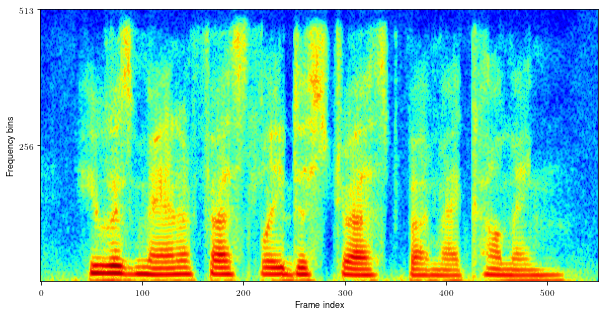

In [16]:
# plot the spectrogram of the generated waveform
plot_API.plot_API(output_waveform[0, :, 0].numpy(), plot_lib.plot_spec, 'single')

The sound quality is limited. The model may not be well trained, or the model structure can be improved.

Your suggestion is welcome.

### 2.3 Look inside the inference stage

Let us look inside the inference loop.

The codes below are borrowed from `Model.inference()` and `LPCNetV1.inference()`


#### Preparation

In [17]:
# prepare the normed input features

# from Model.inference()

# note that the input acoustic features may be extracted using a smaller frame shift
# it may be different with the frame shift used in LP analysis
#
# In thus a case, we need to re-sample the input features
#
# In this sample, the frame shift of input features is 80
# the frame shift of LPC is 160, thus, down-sample by a factor of 2
# 
cond_feat = input_tensor[:, ::m_ilpcnet.feat_upsamp]
cond_feat_normed = m_ilpcnet.normalize_input(cond_feat)

# prepare pitch embedding
# from LPCNetV1.inference()
batch, frame_num, _ = cond_feat.shape
xtyp = cond_feat.dtype
xdev = cond_feat.device

In [18]:
# quantize F0 and F0 embedding
with torch.no_grad():
    pitch_quantized = m_ilpcnet.m_lpcnet._convert_pitch(cond_feat[:, :, -1])
    pitch_emb = m_ilpcnet.m_lpcnet.m_emb_f0(pitch_quantized)

In [19]:
print('pitch_quantized shape: {:s}'.format(str(pitch_quantized.shape)))
print(' {:d} frames'.format(pitch_quantized.shape[1]))

print('pitch_emb shape: {:s}'.format(str(pitch_emb.shape)))
print(' {:d} frames'.format(pitch_emb.shape[1]))
print(' {:d} dimensions per frame'.format(pitch_emb.shape[-1]))

pitch_quantized shape: torch.Size([1, 275])
 275 frames
pitch_emb shape: torch.Size([1, 275, 64])
 275 frames
 64 dimensions per frame


In [20]:
# just to check quantized pitch of one frame
frame_idx = 50
print("The pitch value of {:d}-th frame is {:f} Hz".format(frame_idx, cond_feat[0, frame_idx, -1].numpy()))
print("The quantized pitch index of {:d}-th frame is {:d}".format(frame_idx, pitch_quantized[0, frame_idx].numpy()))

# You can try this API to plot the two curves
#plot_API.plot_API([cond_feat[0, :, -1].numpy(), pitch_quantized[0].numpy()],
#                  plot_lib.plot_signal, 'v', 
#                  {'sharex': True, 'subylabels': [{'ylabel': 'Pitch (Hz)'}, {'ylabel': 'Quantized pitch index'}], 
#                   'subtitle': [{'title': 'Input pitch (F0)'}, {'title': 'Quantized pitch'}]})

The pitch value of 50-th frame is 195.121948 Hz
The quantized pitch index of 50-th frame is 81


#### step1. predict reflection coefficients

In [21]:
with torch.no_grad():
    rc_coef_pre, gain_pre = m_ilpcnet.m_lpcnet.m_cond_net(cond_feat)

In [22]:
print('rc_coef_pre shape: {:s}'.format(str(rc_coef_pre.shape)))
print(' {:d} frames'.format(rc_coef_pre.shape[1]))
print(' {:d} reflection coefficients per frame'.format(rc_coef_pre.shape[-1]))

rc_coef_pre shape: torch.Size([1, 275, 15])
 275 frames
 15 reflection coefficients per frame


In [23]:
# Notice how the maximum and minmum value of rc_coef is within (-1, 1)
print("Maximum: ", rc_coef_pre.max())
print("Minimum: ", rc_coef_pre.min())

# You can try this API to plot the reflection coefficients
# plot_API.plot_API(rc_coef_pre[0].numpy().T, plot_lib.plot_imshow, 'single')

Maximum:  tensor(0.9810)
Minimum:  tensor(-0.8953)


#### step2. convert rc2lpc

In [24]:
with torch.no_grad():
    lpc_coef_pre = m_ilpcnet.m_lpcnet.m_lpc.LPC_rc2lpc(rc_coef_pre)

In [25]:
print('lpc_coef_pre shape: {:s}'.format(str(lpc_coef_pre.shape)))
print(' {:d} frames'.format(lpc_coef_pre.shape[1]))
print(' {:d} LP coefficients per frame'.format(lpc_coef_pre.shape[-1]))

lpc_coef_pre shape: torch.Size([1, 275, 16])
 275 frames
 16 LP coefficients per frame


In [26]:
lpc_coef_pre

tensor([[[ 1.0000, -0.3677,  0.4987,  ..., -0.0674, -0.0426,  0.0352],
         [ 1.0000, -0.5089,  0.3712,  ..., -0.0084, -0.0600,  0.0723],
         [ 1.0000, -0.5401,  0.3527,  ..., -0.0846, -0.0384,  0.0518],
         ...,
         [ 1.0000,  0.0916,  0.0955,  ..., -0.0313,  0.0139,  0.0305],
         [ 1.0000,  0.1044,  0.0428,  ..., -0.0358, -0.0023,  0.0275],
         [ 1.0000,  0.0748,  0.0386,  ..., -0.0621, -0.0071,  0.0022]]])

`lpc_coef_pre[0, n, :]` is the LP coefficients $\{1, a_{1, n}, \cdots, a_{M, n}\}$ for the $n$-th frame. The order $M$ is 15. 

In [27]:
frame_idx = 50
one_frame_lpc_coef = lpc_coef_pre[0, frame_idx, :]

print("LP coefficients for the {:d}-th frame is:".format(frame_idx))
print(" a_0 = 1")
for order in range(1, lpc_coef_pre.shape[-1]):
    print(" a_{:d} = {:f}".format(order, one_frame_lpc_coef[order]))

LP coefficients for the 50-th frame is:
 a_0 = 1
 a_1 = -1.133005
 a_2 = 0.281666
 a_3 = -0.263224
 a_4 = 0.304499
 a_5 = -0.609167
 a_6 = 0.709705
 a_7 = -0.600230
 a_8 = 0.522026
 a_9 = -0.263749
 a_10 = 0.276866
 a_11 = -0.505059
 a_12 = 0.368073
 a_13 = -0.044504
 a_14 = 0.197688
 a_15 = -0.175889


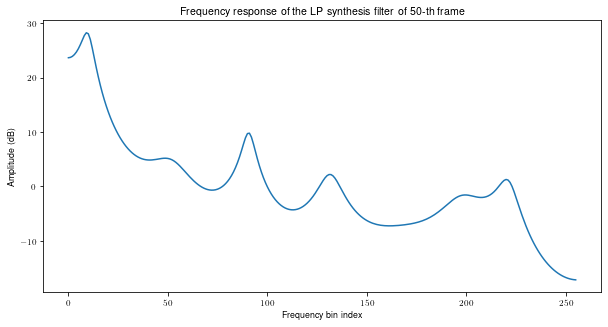

In [28]:
# Let's plot the frequency response for one frame
# compute the spectrum for this frame
from scipy import signal

fft_number = 512

_, lpc_spec = signal.freqz([1], one_frame_lpc_coef.numpy(), worN = int(fft_number/2))
fig, axis = plot_API.plot_API(20*np.log10(np.abs(lpc_spec+1e-20)), plot_lib.plot_signal, 'single',
                              {'ylabel': 'Amplitude (dB)', 'xlabel': 'Frequency bin index',
                               'title': 'Frequency response of the LP synthesis filter of {:d}-th frame'.format(frame_idx)})

In [29]:
# Let's try to plot the frequency response for all the frames

def get_freq_res(lpc_coef):
    fft_number = 512
    freq_res = np.zeros([lpc_coef.shape[0], fft_number//2])
    
    for idx in range(lpc_coef.shape[0]):
        _, lpc_spec = signal.freqz([1], lpc_coef[idx], worN = int(fft_number/2))
        freq_res[idx] = 20*np.log10(np.abs(lpc_spec+1e-20))
    return freq_res

freq_res = get_freq_res(lpc_coef_pre[0].numpy())

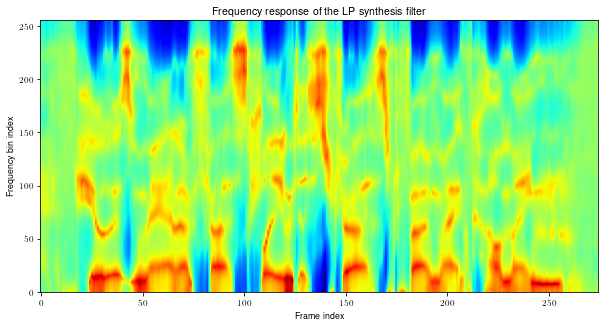

In [30]:
fig, axis = plot_API.plot_API(
    freq_res.T, plot_lib.plot_imshow, 'single',
    {'xlabel': 'Frame index', 'ylabel': 'Frequency bin index',
     'title': 'Frequency response of the LP synthesis filter'})

#### step3. frame rate network

In [31]:
lpccond_feat = m_ilpcnet.m_lpcnet.m_net_framerate(torch.cat([cond_feat_normed, pitch_emb], dim=-1))

In [32]:
print('lpccond_feat shape: {:s}'.format(str(lpccond_feat.shape)))
print(' {:d} frames'.format(lpccond_feat.shape[1]))
print(' {:d} dimensions per frame'.format(lpccond_feat.shape[-1]))

lpccond_feat shape: torch.Size([1, 275, 256])
 275 frames
 256 dimensions per frame


#### step4. step by step waveform generation

In [33]:
# waveform length = frame num * up-sampling rate
wavlen = frame_num * m_ilpcnet.m_lpcnet.m_fs

# many buffers
#  buf to store output waveofmr
wavbuf = torch.zeros([batch, wavlen, 1], dtype=xtyp, device=xdev)

#  buf to store excitation signal
exibuf = torch.zeros_like(wavbuf)

#  buf to store LPC predicted wave
prebuf = torch.zeros_like(wavbuf)

#  buf to store LPC input x[n-1], ... x[n-order+1]
lpcbuf = torch.zeros([batch, m_ilpcnet.m_lpcnet.m_lpc_order-1, 1], 
                     dtype=xtyp, device=xdev)

#  mean and std buf 
meanbuf = torch.zeros_like(wavbuf)
stdbuf = torch.zeros_like(wavbuf)

In [34]:
with torch.no_grad():
    # loop
    for idx in range(0, wavlen):

        # monitor the generation process
        if idx % 1000 == 0:
            print(idx, end=' ', flush=True)


        # frame index for the idx-th time step
        frame_idx = idx // m_ilpcnet.m_lpcnet.m_fs


        # 4.1 LP predicted wav 
        # pre_raw = [- (x[n-1] * a_1 + x[n-2] * a_2 ... )]
        # 
        # This is the API
        #pre_raw = self.m_lpc.LPCSynthesisPytorchCore(
        #    lpc_coef_pre[:, frame_idx : frame_idx+1, :], lpcbuf)
        # 
        # We can also directly compute it
        #  lpc coef of this time step 
        tmp_lpc_coef = lpc_coef_pre[:, frame_idx : frame_idx+1, :]
        lpc_order = tmp_lpc_coef.shape[-1]

        # lpcbuf is (batch, lpc_order-1, 1)
        # flip so that data is in order [x[n-1], ..., x[n-order+1]]
        # pre_sample will be (batch, lpc_order - 1)
        pre_sample = torch.flip(lpcbuf, dims=[1]).squeeze(-1)


        # tmp_lpc_coef[:, 0, 1:] has shape (batch, lpc_order - 1)
        #    = [ ... [a_1, a_2, ... a_M] ... ]
        # pre_sample has shape (batch, lpc_order - 1) 
        # predicted has shape (batch, )
        predicted = torch.sum(tmp_lpc_coef[:, 0, 1:] * pre_sample, dim=1)
        # unsqueeze to (batch, 1, 1)
        # -(x[n-1] * a[2] + ...)
        pre_raw = -1 * predicted.unsqueeze(-1).unsqueeze(-1)

        # save it (for debugging)
        prebuf[:, idx:idx+1, :] = pre_raw

        # 4.2 predict excitation
        # feedback
        if idx == 0:
            wav_raw = torch.zeros_like(pre_raw)

        #   predict mean, std
        mean, std = m_ilpcnet.m_lpcnet.m_net_out(
            lpccond_feat[:, frame_idx:frame_idx+1], wav_raw, idx)
        #   save mean and std
        meanbuf[:, idx:idx+1, :]= mean
        stdbuf[:, idx:idx+1, :] = std

        #   sampling
        exi_raw = torch.randn_like(mean) * std * 0.7 + mean

        #   save excit (for debugging)
        exibuf[:, idx:idx+1,:] = exi_raw 

        # 4.3 waveform output
        #   excit[n] + [-(x[n-1] * a_1 + x[n-2] * a_2 ... )]
        wav_raw = exi_raw + pre_raw

        #    save waveform 
        wavbuf[:, idx:idx+1,:] = wav_raw
        #    save it to the LPC buffer. 
        #    It will be used by LPCSynthesisPytorchCore
        lpcbuf = torch.roll(lpcbuf, -1, dims=1)
        lpcbuf[:, -1, :] = wav_raw[:, 0, :]

    # After generation, do de-emphasis if necessary
    generated_wav = m_ilpcnet.m_lpcnet.m_lpc.deemphasis(wavbuf)

0 1000 2000 3000 4000 5000 6000 7000 8000 9000 10000 11000 12000 13000 14000 15000 16000 17000 18000 19000 20000 21000 22000 23000 24000 25000 26000 27000 28000 29000 30000 31000 32000 33000 34000 35000 36000 37000 38000 39000 40000 41000 42000 43000 

In [35]:
import IPython.display
IPython.display.Audio(generated_wav[0, :, 0].numpy(), rate=sampling_rate, normalize=False)

#### Check signals

(<Figure size 720x432 with 3 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x155518f0c670>)

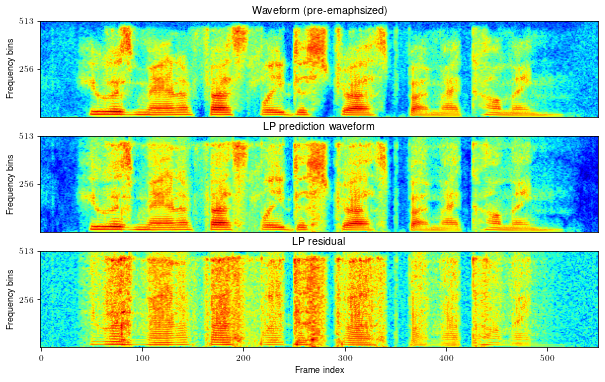

In [36]:
# plot the spectrogram of the generated waveform
plot_API.plot_API([wavbuf[0, :, 0].numpy(), 
                   prebuf[0, :, 0].numpy(), 
                   exibuf[0, :, 0].numpy()], 
                  plot_lib.plot_spec, 'v', 
                  {'sharex': True, 'xlabel': 'Frame index', 'figsize': (10, 6),
                   'subtitle': [{'title': 'Waveform (pre-emaphsized)'}, {'title': 'LP prediction waveform'}, {'title': 'LP residual'}]})

In [37]:
# Generated waveform (before de-emphasis)
IPython.display.Audio(wavbuf[0, :, 0].numpy(), rate=sampling_rate, normalize=False)

In [38]:
# LP prediction
IPython.display.Audio(prebuf[0, :, 0].numpy(), rate=sampling_rate, normalize=False)

In [39]:
# LP residual
IPython.display.Audio(exibuf[0, :, 0].numpy(), rate=sampling_rate, normalize=False)

#### Check the mean and std of the Gaussian distribution for LP residual

(<Figure size 720x288 with 2 Axes>,
  <matplotlib.axes._subplots.AxesSubplot at 0x155518e90490>])

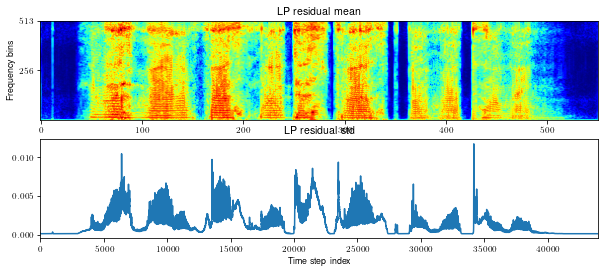

In [40]:
# plot the spectrogram of the generated waveform
plot_API.plot_API2([meanbuf[0, :, 0].numpy(), 
                    stdbuf[0, :, 0].numpy()], 
                   [plot_lib.plot_spec, plot_lib.plot_signal], [[[0, 1], [0, 1]], [[1, 2], [0, 1]]], 
                  {'figsize': (10, 4),
                   'subtitle': [{'title': 'LP residual mean'}, {'title': 'LP residual std'}], 
                   'subaxis': [{}, {'xlim': (0, stdbuf.shape[1])}],
                   'subxlabel': [{'xlabel': 'Frame index'}, {'xlabel': 'Time step index'}],
                   'vspace': 2
                  })

## Remark

This demonstration book shows the inference progess of iLPCNet.

The training process is slightly more complicated in implementation. Please check the code in `../project/05-nn-vocoder/iLPCNet`.

That's all